In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sympy

<AxesSubplot:xlabel='x'>

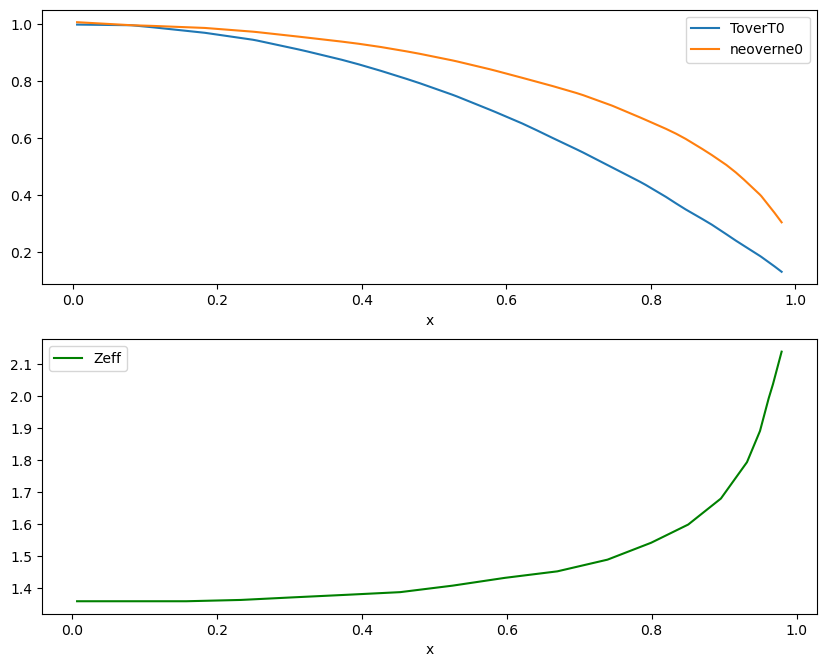

In [2]:
T_data = pd.read_csv("/home/dominik/houlberg-profiles.csv").drop("Zeff", axis=1)
zeff = pd.read_csv("/home/dominik/houlberg-profiles-zeff.csv")

fig, (ax, ax2) = plt.subplots(2)
T_data.plot(x="x", ax=ax)
zeff.plot(x="x", ax=ax2, c="g")

In [3]:
import sympy
sympy.init_printing()
rho = sympy.symbols("rho")
n_i = sympy.Function('n_i')(rho)
n_e = sympy.Function('n_e')(rho)
n_C = sympy.symbols('n_C') # flat
Z_eff = sympy.Function("Z_{eff}")(rho);

Sprawdziłem definicję $Z_{eff}$ u Hirshmana:

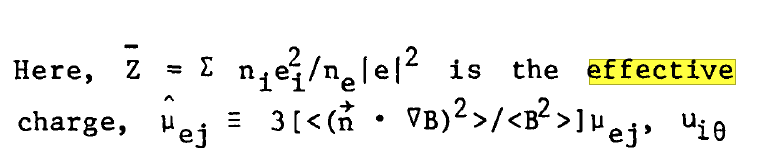

więc:

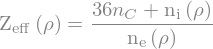

In [4]:
Z_eff_from_elems = (n_i + 6**2 * n_C) / n_e
equation = sympy.Eq(Z_eff,
                    Z_eff_from_elems)

Więc bardzo proste przekształcenie daje:

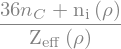

In [5]:
n_e_solution = sympy.solve(equation, n_e)[0]

In [6]:
values_at_zero = {   # blisko środka, rho = 0
    Z_eff.subs(rho, 0): 1.36,
    n_i.subs(rho, 0): 6.5e19,
    n_C: 5e18,
}
values_at_zero[n_e] = ne0_value = n_e_solution.subs(rho, 0).subs(values_at_zero)

values_at_zero

In [43]:
T0, Ta = sympy.symbols(r"T_0 t_a")
T_profile = T0 * ((1 - Ta) * (1 - rho**2) + Ta)

In [45]:
T_outputs = T_profile, T_profile.diff(rho)

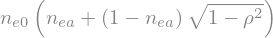

In [46]:
ne0, nea, = sympy.symbols(r"n_{e0} n_{ea}")
n_e_profile = ne0 * ((1 - nea) * sympy.sqrt(1 - rho**2) + nea)

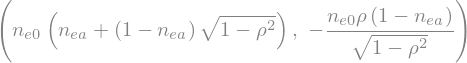

In [47]:
n_e_outputs = n_e_profile, n_e_profile.diff(rho)

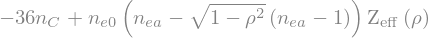

In [48]:
n_i_profile = sympy.solve(equation, n_i)[0].subs(n_e, n_e_profile).simplify()

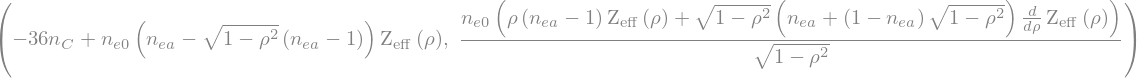

In [49]:
n_i_outputs = n_i_profile, n_i_profile.diff(rho).simplify()

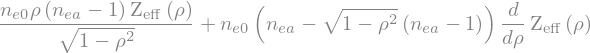

In [50]:
n_i_profile.diff(rho).subs(values_at_zero)

In [61]:
values_general = {
    ne0: ne0_value,
    nea: 0.22,
    Ta: 0.09,
    T0: 1, # keV
    n_C: 5e18,
}

In [62]:
Zeff_vals = zeff.Zeff

0     1.35992
1     1.35992
2     1.35992
3     1.36397
4     1.37207
5     1.38017
6     1.38828
7     1.40853
8     1.43284
9     1.45309
10    1.48956
11    1.54222
12    1.59894
13    1.67996
14    1.79340
15    1.89062
16    1.99190
17    2.03647
18    2.13775
Name: Zeff, dtype: float64

In [63]:
Zeff_grad = np.gradient(Zeff_vals, zeff.x)

array([0.        , 0.        , 0.02687637, 0.08346342, 0.10979527,
       0.1098658 , 0.19607106, 0.30810041, 0.30811783, 0.40581786,
       0.71258948, 1.00096701, 1.47364756, 2.54784026, 4.65750425,
       7.26085422, 7.79920422, 7.79920422, 8.48952221])

In [96]:
from scipy import interpolate

In [154]:
spl = interpolate.(zeff.x, zeff.Zeff)

fig, (ax1, ax2) = plt.subplots(2)
zeff.plot(x="x", lw=5, ax=ax1)
ax1.plot(zeff.x, spl(zeff.x))
plt.plot(zeff.x, spl.derivative(1)(zeff.x))

TypeError: __init__() missing 1 required positional argument: 't'

In [141]:
def funcify(expr, rho_vals, Zeff_spl, values):
    functions = expr.subs(values), expr.diff(rho).subs(values)
    args = (rho, Z_eff, Z_eff.diff(rho))
    return sympy.lambdify(args,
                   functions,
                   modules='numpy')(rho_vals, Zeff_spl(rho_vals), Zeff_spl.derivative(1)(rho_vals))
T_vals, dT_vals = funcify(T_profile, T_data.x.values, spl, values_general)

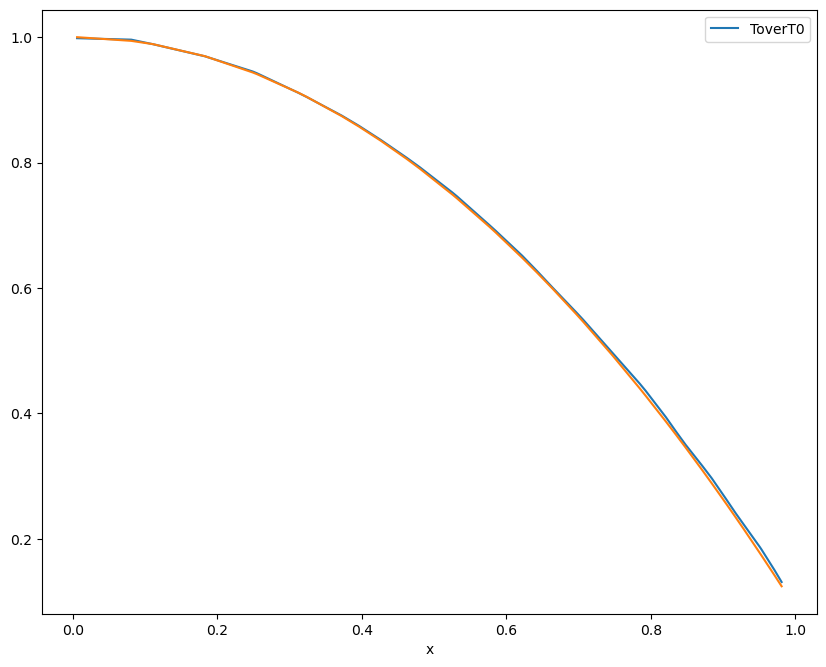

In [142]:
T_data.plot(x="x", y="ToverT0")
plt.plot(T_data.x.values, T_vals)

In [143]:
n_e_vals, dn_e_vals = funcify(n_e_profile, T_data.x.values, spl, values_general)
n_e_vals

array([1.80144856e+20, 1.79689898e+20, 1.79284845e+20, 1.79284532e+20,
       1.77783842e+20, 1.77782015e+20, 1.75728918e+20, 1.75513641e+20,
       1.73136551e+20, 1.72578830e+20, 1.70059323e+20, 1.68669747e+20,
       1.66745364e+20, 1.64256416e+20, 1.62872246e+20, 1.59219531e+20,
       1.58651209e+20, 1.54422717e+20, 1.53574181e+20, 1.49665603e+20,
       1.47324429e+20, 1.44683551e+20, 1.40459635e+20, 1.39100284e+20,
       1.33281480e+20, 1.32942436e+20, 1.26728671e+20, 1.25260724e+20,
       1.19868282e+20, 1.16937767e+20, 1.14077631e+20, 1.08597536e+20,
       1.05233378e+20, 9.95611485e+19, 9.55038692e+19, 9.17396906e+19,
       8.31818077e+19, 8.22350620e+19, 7.31350944e+19, 6.69074987e+19])

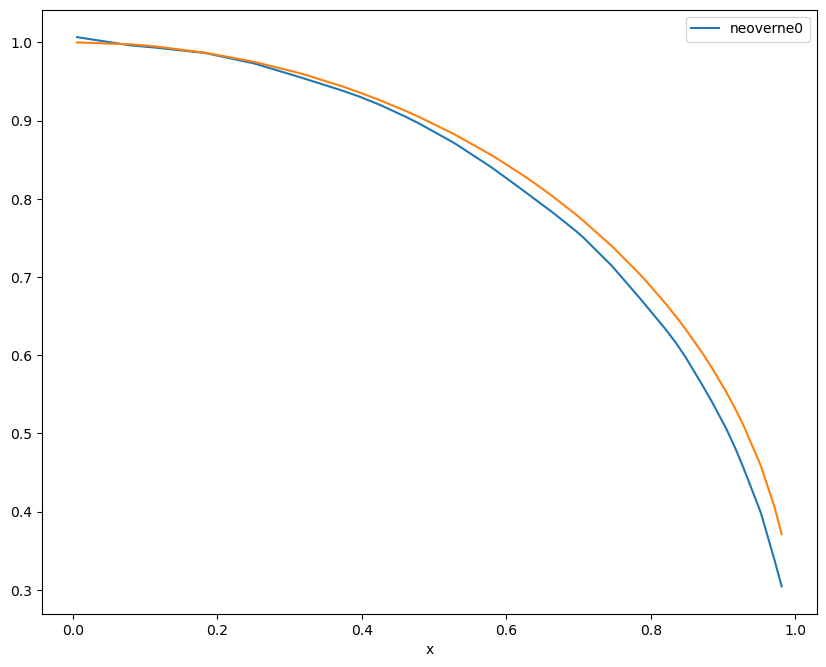

In [144]:
T_data.plot(x="x", y="neoverne0")
plt.plot(T_data.x.values, n_e_vals/values_general[ne0])

In [145]:
n_i_vals, dn_i_vals = funcify(n_i_profile, T_data.x.values, spl, values_general)
n_i_vals

array([            nan,  6.43638862e+19,  6.38130462e+19,  6.38126208e+19,
        6.18519412e+19,  6.18499021e+19,  5.99972337e+19,  5.98196006e+19,
        5.76814211e+19,  5.71356879e+19,  5.45561912e+19,  5.30701319e+19,
        5.09641533e+19,  4.82682968e+19,  4.70569073e+19,  4.42603558e+19,
        4.37953208e+19,  4.01946058e+19,  3.94235364e+19,  3.55173114e+19,
        3.29342133e+19,  2.99882243e+19,  2.56167022e+19,  2.43342455e+19,
        1.91608016e+19,  1.88730446e+19,  1.36891276e+19,  1.24128826e+19,
        7.54154497e+18,  4.83228660e+18,  2.08094982e+18, -2.86241188e+18,
       -5.67809799e+18, -1.05837250e+19, -1.36272749e+19, -1.64908529e+19,
       -2.19718624e+19, -2.22807355e+19, -2.88802329e+19,             nan])